## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
# import tensorflow as tf
# from tensorflow import keras

# from tensorflow.keras import layers
# from tensorflow.keras import regularizers
# import tensorflow.compat.v2.feature_column as fc

# #!pip install -q git+https://github.com/tensorflow/docs

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots

#print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v5

# from utils.models import make_input_fn
# from utils.models import performanceTesting,scoreFunction
# from utils.plotting import plot_confusion_matrix

C:\Users\PC\AppData\Local\Temp\tmpa79pyd3o\tensorboard_logs


## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec.csv
1: aggregateTAQ_May2020_30sec.csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


2


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


In [3]:
files = os.listdir('../AzureML/Output_from_cloud')
files

['Archieve',
 'hyperparameters_lr_v1_1.txt',
 'hyperparameters_lr_v2_4.txt',
 'hyperparameters_lr_v3_1.txt',
 'hyperparameters_nn_v4.txt',
 'metrics_lr_v1_1.txt',
 'metrics_lr_v2_4.txt',
 'metrics_lr_v3_1.txt',
 'metrics_nn_v4.txt']

In [4]:
hyperfiles_nn = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('hyper' in i) & ('nn' in i)]
metricfiles_nn = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('metric' in i) & ('nn' in i)]

In [5]:
hyperfiles_nn

['hyperparameters_nn_v4.txt']

# Loading Neural Network

## Hyperparameters

In [6]:
### Reading in the file

with open('../AzureML/Output_from_cloud/'+hyperfiles_nn[-1],'r') as file:
    content = file.readlines()

## Containers for the data
all_ids = []
all_parameters = []

## Going over each line in the text file
for a in np.arange(len(content[0:-1])):
    
    ## Split the lines on tabs
    temp_parameters = re.split('[\t]',content[a])[1]
    
    ## Basic string cleaning, i.e. removing redundant characters
#     test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
#                                                                        .replace('}','')\
#                                                                        .replace('\n','')\
#                                                                        .replace('"',''))]
    test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                       .replace('}','')\
                                                                       .replace('\n','')\
                                                                       .replace('"','')\
                                                                       .replace('--','')
                                                                       .replace('\'',''))]
    
    ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
    ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
    test = {i[0]:i[1] for i in test}
    
    # Constructing the dataframe
    if a == 0:
        parameters = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])
    
    else:
        
        parameters.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)

## Metrics

In [7]:
## Readidng in the file
with open('../AzureML/Output_from_cloud/'+metricfiles_nn[-1],'r') as file:
    content = file.readlines()

## Containers
t11 = []
t12 = []
t13 = []

t21 = []
t22 = []
t23 = []

## Going over each line
for i in np.arange(len(content)):#
    
    ## Split each line on tabs
    temp = re.split('\t',content[i].replace('\n',''))
    
    #print(temp)
    
    ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
    ## and 2. a time series of a metric for each model.
    
    ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
    ## It stored separately for the time series.
    if len(temp[2]) < 50:

        t11.append(temp[0])
        t12.append(temp[1])
        t13.append(temp[2])
    
    ## Time series
    else:
    
        container = np.zeros(155)
        temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

        container[0:len(temp1)] = temp1
        container[len(temp1):] = temp1[-1]

        t21.append(temp[0])
        t22.append(temp[1])
        t23.append(container)        

## Storing the time series in a dataframe
arrays = [t21,t22]
tuples = list(zip(*arrays))

runningMetrics = pd.DataFrame(np.array(t23),
                              index=pd.MultiIndex.from_tuples(tuples),
                              columns = [np.arange(155).astype(str)]
                             )
## Storing the final metrics in a dataframe.
arrays = [t11,t12]
tuples = list(zip(*arrays))
finalMetrics = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [8]:
## Resetting indcies and rename columns
runningMetrics = runningMetrics.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics.columns = runningMetrics.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics['id'] = [re.split('_',i)[-1] for i in runningMetrics.run_id]

## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table = pd.pivot_table(runningMetrics[['run_id','metric','154','id']],index='id',columns=['metric'])
table.columns = table.columns.get_level_values(1)
table = table.round(5).reset_index()

## Preparing the parameter dataframe.
parameters = parameters.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters['id'] = [re.split('_',i)[-1] for i in parameters.run_id]

## Creating the combined table
combined_table = parameters.merge(table,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
115,HD_81ace623-e09b-4393-8a5e-131ea8749a35_883,sigmoid,softmax,1,1,10725,0.1,3,3,128,...,0,std,32,883,0.80363,0.58075,0.98257,0.80358,0.66548,0.77074
781,HD_81ace623-e09b-4393-8a5e-131ea8749a35_218,tanh,softmax,1,0,21450,0,5,1,64,...,0,pow,32,218,0.79064,0.57710,0.99908,0.79060,0.65135,0.80627
997,HD_81ace623-e09b-4393-8a5e-131ea8749a35_5,leakyrelu,softmax,1,1,21450,0.5,3,3,128,...,0,quantgau,128,5,0.78380,0.60282,0.90322,0.78376,0.62677,0.84667
928,HD_81ace623-e09b-4393-8a5e-131ea8749a35_72,tanh,softmax,1,1,3300,0.2,3,3,128,...,1,stacked,64,72,0.78185,0.61228,0.89609,0.78181,0.62734,0.84895
128,HD_81ace623-e09b-4393-8a5e-131ea8749a35_871,tanh,softmax,1,1,10725,0,3,0,128,...,0,quantgau,32,871,0.78175,0.60582,0.92492,0.78172,0.62636,0.85098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,HD_81ace623-e09b-4393-8a5e-131ea8749a35_185,relu,linear,0,1,3300,0.3,5,3,128,...,1,None,128,185,0.00000,0.19641,0.94736,0.00000,0.19952,0.95143
304,HD_81ace623-e09b-4393-8a5e-131ea8749a35_695,sigmoid,linear,0,0,3300,0.1,1,3,64,...,1,quantgau,128,695,0.00000,0.19329,0.89643,0.00000,0.18706,0.91432
195,HD_81ace623-e09b-4393-8a5e-131ea8749a35_803,tanh,linear,0,0,21450,0.3,3,0,32,...,1,minmax,32,803,0.00000,0.45457,0.68465,0.00000,0.45333,0.68717
861,HD_81ace623-e09b-4393-8a5e-131ea8749a35_137,sigmoid,linear,0,1,10725,0.5,5,3,128,...,0,stacked,64,137,0.00000,0.16547,1.59072,0.00000,0.17433,1.59977


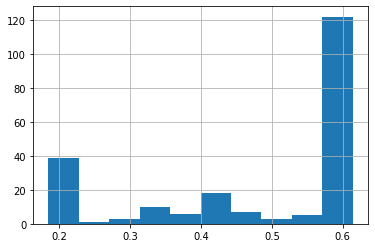

In [9]:
runningMetrics[(runningMetrics.metric=='Accuracy')&\
               (np.isin(runningMetrics.id,parameters[parameters['label-type']=='2'].id.values))].sort_values('154')['154'].hist()

In [10]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc = pd.pivot_table(combined_table[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc = pd.pivot_table(combined_table[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc = pd.DataFrame(np.sort(temp_auc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc = pd.DataFrame(np.sort(temp_acc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc.columns.get_level_values(1))#.loc[0:10]
# final_output

In [11]:
tempFinal_v0 = combined_table[np.isin(combined_table.AUC,final_output_auc.loc[0].values.flatten())]
tempFinal_v0.index = tempFinal_v0.loc[:,'label-type']
tempFinal_v0

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
2,HD_81ace623-e09b-4393-8a5e-131ea8749a35_883,sigmoid,softmax,1,1,10725,0.1,3,3,128,...,0,std,32,883,0.80363,0.58075,0.98257,0.80358,0.66548,0.77074
4,HD_81ace623-e09b-4393-8a5e-131ea8749a35_743,relu,softmax,1,0,10725,0,3,3,128,...,1,std,32,743,0.75291,0.39708,1.49211,0.75284,0.46585,1.25437
1,HD_81ace623-e09b-4393-8a5e-131ea8749a35_65,leakyrelu,softmax,0,1,10725,0,5,1,128,...,0,std,64,65,0.74085,0.38183,1.54324,0.74076,0.63645,0.77408
0,HD_81ace623-e09b-4393-8a5e-131ea8749a35_818,relu,softmax,1,1,10725,0,5,1,128,...,1,pow,128,818,0.71117,0.53313,0.97092,0.71096,0.74884,0.49957
3,HD_81ace623-e09b-4393-8a5e-131ea8749a35_737,tanh,softmax,1,1,3300,0,5,0,32,...,0,pow,128,737,0.68440,0.27445,1.66672,0.68431,0.41546,1.36253


In [12]:
tempFinal_v1 = combined_table[np.isin(combined_table.Accuracy,final_output_acc.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1.index = tempFinal_v1.loc[:,'label-type']
tempFinal_v1

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
0,HD_81ace623-e09b-4393-8a5e-131ea8749a35_706,leakyrelu,softmax,0,0,10725,0.4,1,3,64,...,0,quantgau,128,706,0.57765,0.55382,0.67447,0.57746,0.55565,0.67536
1,HD_81ace623-e09b-4393-8a5e-131ea8749a35_390,leakyrelu,softmax,1,0,10725,0.5,0,3,128,...,1,pow,64,390,0.62001,0.43072,1.04843,0.61998,0.44065,1.04593
2,HD_81ace623-e09b-4393-8a5e-131ea8749a35_283,tanh,softmax,1,1,3300,0.1,3,2,32,...,0,stacked,128,283,0.76304,0.61409,0.87683,0.76298,0.61164,0.87896
3,HD_81ace623-e09b-4393-8a5e-131ea8749a35_213,tanh,softmax,0,1,21450,0.5,5,0,128,...,1,pow,64,213,0.64187,0.30243,1.51325,0.64186,0.30381,1.51441
4,HD_81ace623-e09b-4393-8a5e-131ea8749a35_528,tanh,softmax,1,1,10725,0.1,3,0,128,...,0,std,32,528,0.73196,0.42030,1.35104,0.73192,0.41582,1.35792


In [13]:
tempFinal_v0.loc['0']

run_id                   HD_81ace623-e09b-4393-8a5e-131ea8749a35_818
activation-inner                                                relu
activation-output                                            softmax
batch-norm                                                         1
batch-shuffle                                                      1
batch-size                                                     10725
dropout-ratio                                                      0
feature-lags                                                       5
featureset                                                         1
first-layer-neurons                                              128
label-type                                                         0
learning-rate                                                    0.1
n-epochs                                                         150
n-layers                                                           3
nn-type                           

## Structuring for visualisation

In [14]:
first_step = tempFinal_v0.copy(deep=True).drop(['run_id','label-type','n-epochs'],axis=1).sort_index().round({'AUC':3,
                                                                                                              'Accuracy':3,
                                                                                                              'Loss':3,
                                                                                                              'Train AUC':3,
                                                                                                              'Train Accuracy':3,
                                                                                                              'Train Loss':3})

###     First variables for indentification, the data related variables, estimation parameters, model parameters and then performance.
columns_on_top = ['nn-type','id','featureset','pre-processing','pastobs-in-percentage','feature-lags',
                  'batch-norm','batch-shuffle','batch-size','dropout-ratio','learning-rate','n-layers']
residual = [i for i in first_step.columns if i not in columns_on_top]
correct_ordered = []
correct_ordered += columns_on_top
correct_ordered += residual
# first_step.T.loc[correct_ordered,:]

results_table = first_step.T.loc[correct_ordered,:]

iterables = [['nn'], results_table.columns]

results_table.columns = pd.MultiIndex.from_product(iterables, names=['first', 'second'])

results_table

first                       nn                                      
second                       0          1        2        3        4
nn-type                   ffnn       lstm     lstm     ffnn     lstm
id                         818         65      883      737      743
featureset                   1          1        3        0        3
pre-processing             pow        std      std      pow      std
pastobs-in-percentage        1          0        0        0        1
feature-lags                 5          5        3        5        3
batch-norm                   1          0        1        1        1
batch-shuffle                1          1        1        1        0
batch-size               10725      10725    10725     3300    10725
dropout-ratio                0          0      0.1        0        0
learning-rate              0.1       0.01     0.01     0.01    0.001
n-layers                     3          4        4        4        4
activation-inner          relu  leakyrelu  sigmoid     tanh     relu
activation-output      softmax    softmax  softmax  softmax  softmax
first-layer-neurons        128        128      128       32      128
second-layer-neurons       128         64       32      128       32
AUC                      0.711      0.741    0.804    0.684    0.753
Accuracy                 0.533      0.382    0.581    0.274    0.397
Loss                     0.971      1.543    0.983    1.667    1.492
Train AUC                0.711      0.741    0.804    0.684    0.753
Train Accuracy           0.749      0.636    0.665    0.415    0.466
Train Loss                 0.5      0.774    0.771    1.363    1.254

## An example of a box-plot

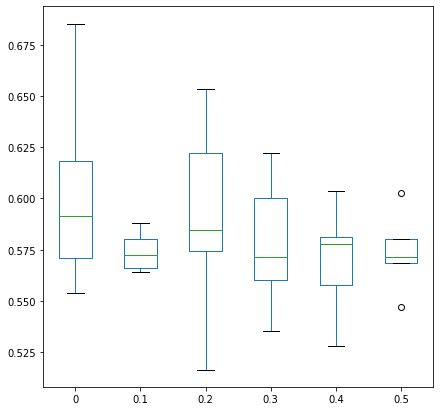

In [15]:
temp = combined_table[(combined_table.loc[:,'label-type']=='0')&\
                      (combined_table.loc[:,'nn-type']=='lstm')&\
                      (combined_table.AUC>0.5)]
temp_2 = pd.pivot_table(temp,values='AUC',columns='dropout-ratio',index='run_id').reset_index()
temp_2.boxplot(list(temp_2.columns[1:]),figsize=(7,7))#temp_2.columns[2:]
plt.grid(b=None)
plt.show()

In [16]:
cols_not_plot = []
cols_to_plot = []

for i,col in enumerate(temp.columns):
    if (temp.loc[:,col].unique().shape[0]>1)&(temp.loc[:,col].unique().shape[0]<7):
        cols_to_plot.append(col)
        print(col,': ',temp.loc[:,col].unique(),'\n')
    else:
        cols_not_plot.append(col)

activation-inner :  ['tanh' 'sigmoid' 'relu' 'leakyrelu'] 

activation-output :  ['softmax' 'linear'] 

batch-norm :  ['1' '0'] 

batch-shuffle :  ['1' '0'] 

batch-size :  ['21450' '10725' '3300'] 

dropout-ratio :  ['0' '0.2' '0.3' '0.4' '0.5' '0.1'] 

feature-lags :  ['5' '3' '0' '1'] 

featureset :  ['0' '3' '2' '1'] 

first-layer-neurons :  ['128' '64' '32'] 

learning-rate :  ['0.01' '0.1' '0.001' '0.0001'] 

n-layers :  ['4' '1' '2' '3'] 

pastobs-in-percentage :  ['1' '0'] 

pre-processing :  ['pow' 'quantgau' 'minmax' 'std' 'None' 'stacked'] 

second-layer-neurons :  ['32' '64' '128'] 



In [17]:
len(cols_to_plot)

14

In [18]:
combined_table.columns

Index(['run_id', 'activation-inner', 'activation-output', 'batch-norm',
       'batch-shuffle', 'batch-size', 'dropout-ratio', 'feature-lags',
       'featureset', 'first-layer-neurons', 'label-type', 'learning-rate',
       'n-epochs', 'n-layers', 'nn-type', 'pastobs-in-percentage',
       'pre-processing', 'second-layer-neurons', 'id', 'AUC', 'Accuracy',
       'Loss', 'Train AUC', 'Train Accuracy', 'Train Loss'],
      dtype='object')

In [19]:
combined_table.loc[:,'n-epochs'].unique()

array(['150'], dtype=object)

# Label types

Label type 0: 2 classes - equal split

Label type 1: 3 classes - equal split

Label type 2: 3 classes - non-equal split

Label type 3: 5 classes - equal split

Label type 4: 5 classes - non-equal split

# Feature sets

features_to_use == 0:
    listOfFeatures = [
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime'
                    ]

features_to_use == 1:
    listOfFeatures = [
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'sector'
                    ]

features_to_use == 2:
    listOfFeatures = [
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime',
                        'stok',
                        'stod',
                        'sstod',
                        'roc',
                        'rsi',
                        'atr',
                        'cci',
                        'dpo',
                        'sma',
                        'ema',
                        'macd',
                        'macd_diff',
                        'macd_signal',
                        'dis5',
                        'dis10'
                        ]

features_to_use == 3: 
    listOfFeatures = [
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'stok',
                    'stod',
                    'sstod',
                    'roc',
                    'rsi',
                    'atr',
                    'cci',
                    'dpo',
                    'sma',
                    'ema',
                    'macd',
                    'macd_diff',
                    'macd_signal',
                    'dis5',
                    'dis10',
                    'sector'
                    ]

In [45]:
x1 = pd.DataFrame({'x^1':'\checkmark'},index=[
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime'
                    ])

x2 = pd.DataFrame({'x^2':'\checkmark'},index=[
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'sector'
                    ])

x3 = pd.DataFrame({'x^3':'\checkmark'},index=[
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime',
                        'stok',
                        'stod',
                        'sstod',
                        'roc',
                        'rsi',
                        'atr',
                        'cci',
                        'dpo',
                        'sma',
                        'ema',
                        'macd',
                        'macd_diff',
                        'macd_signal',
                        'dis5',
                        'dis10'
                        ])

x4 = pd.DataFrame({'x^4':'\checkmark'},index=[
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'stok',
                    'stod',
                    'sstod',
                    'roc',
                    'rsi',
                    'atr',
                    'cci',
                    'dpo',
                    'sma',
                    'ema',
                    'macd',
                    'macd_diff',
                    'macd_signal',
                    'dis5',
                    'dis10',
                    'sector'
                    ])

x5 = pd.DataFrame({'Description':''},index=[
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'stok',
                    'stod',
                    'sstod',
                    'roc',
                    'rsi',
                    'atr',
                    'cci',
                    'dpo',
                    'sma',
                    'ema',
                    'macd',
                    'macd_diff',
                    'macd_signal',
                    'dis5',
                    'dis10',
                    'sector'
                    ])

exo_sets = pd.concat([x1,x2,x3,x4,x5],axis=1).fillna('')
exo_sets

,x^1,x^2,x^3,x^4,Description
pastobs,\checkmark,\checkmark,\checkmark,\checkmark,
spread,\checkmark,\checkmark,\checkmark,\checkmark,
bidsize,\checkmark,\checkmark,\checkmark,\checkmark,
ofrsize,\checkmark,\checkmark,\checkmark,\checkmark,
pastreturns,\checkmark,\checkmark,\checkmark,\checkmark,
intradaytime,\checkmark,\checkmark,\checkmark,\checkmark,
sector,,\checkmark,,\checkmark,
stok,,,\checkmark,\checkmark,
stod,,,\checkmark,\checkmark,
sstod,,,\checkmark,\checkmark,


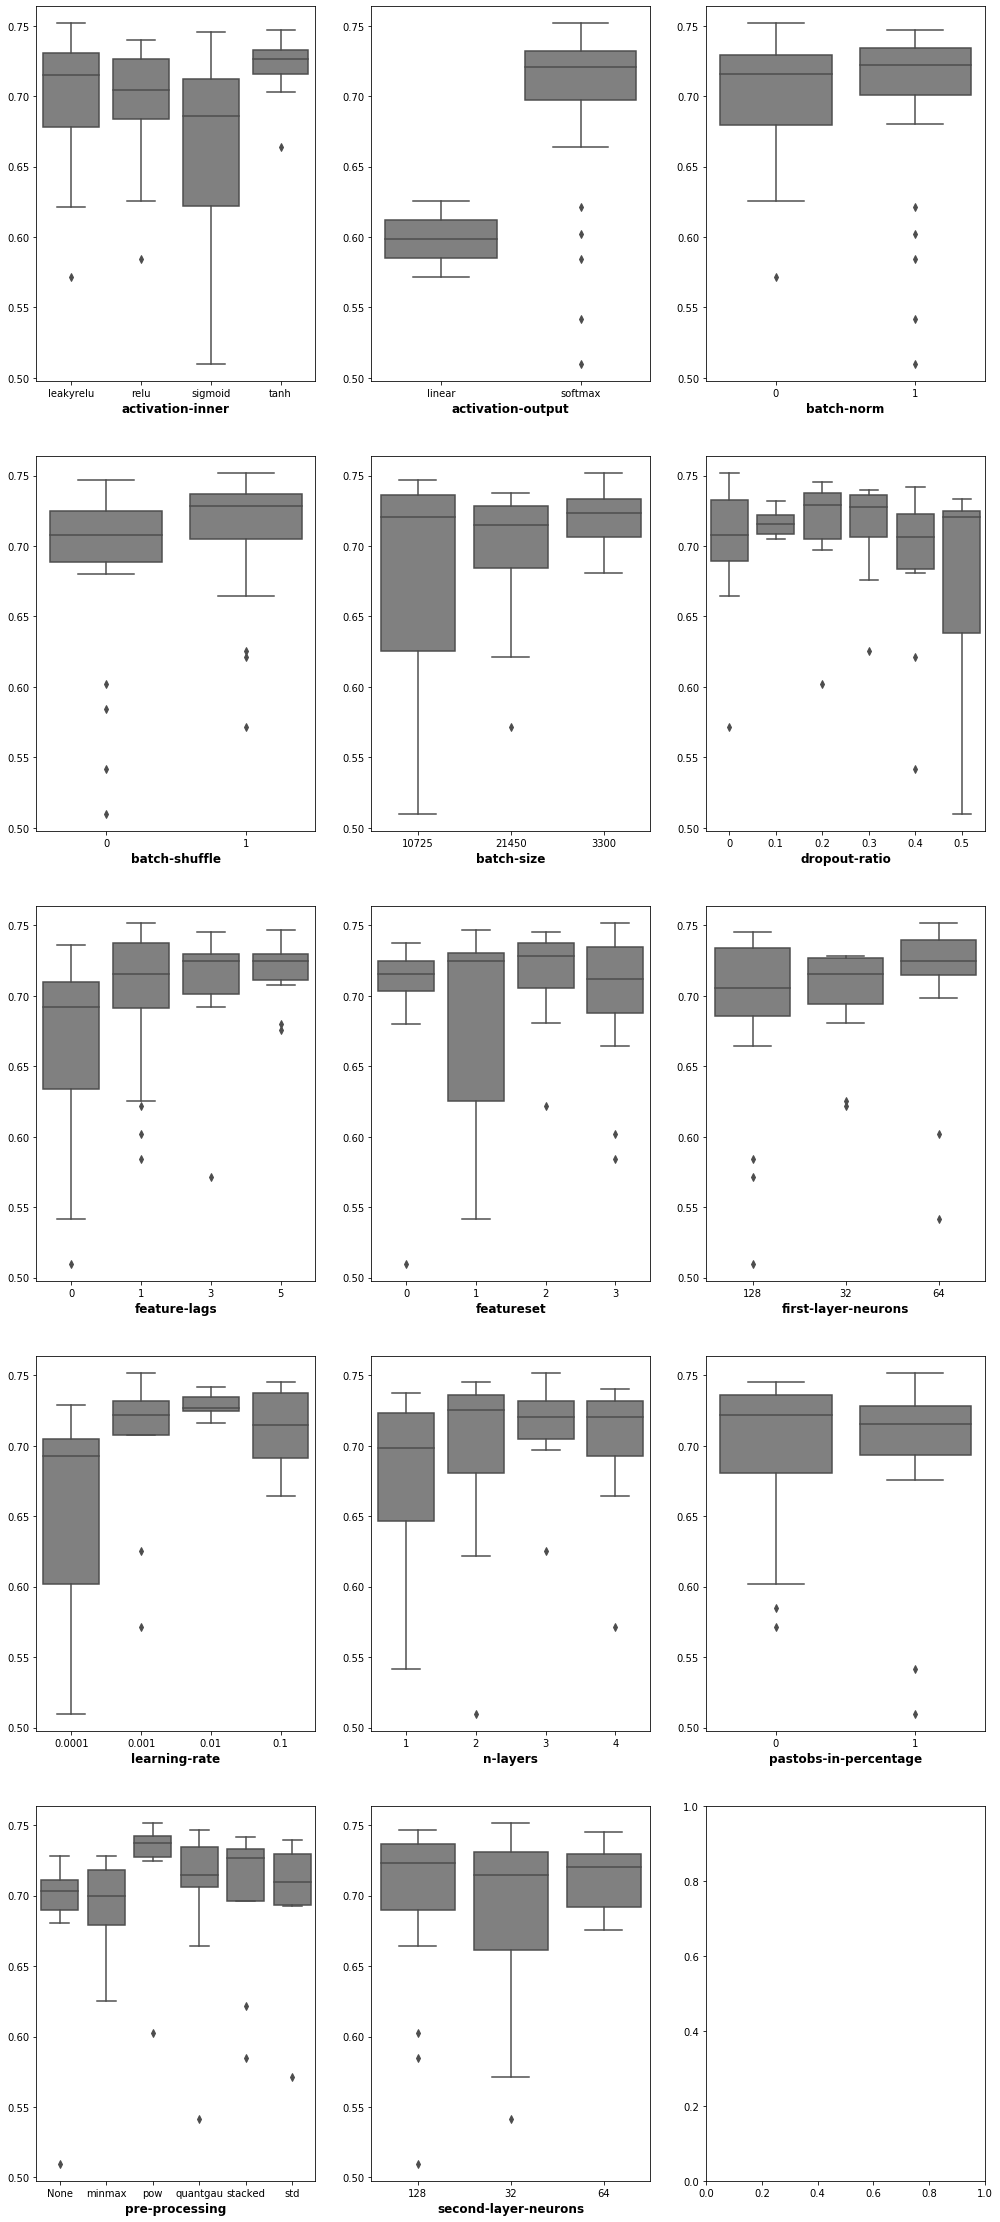

In [20]:
import seaborn as sns

temp = combined_table[(combined_table.loc[:,'label-type']=='4')&\
                      (combined_table.loc[:,'nn-type']=='ffnn')&\
                      (combined_table.AUC>0.5)]

fig,ax = plt.subplots(5,3,figsize=(17,40))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
# plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.weight': 'normal'})
k = 0

for i in np.arange(5):
    for j in np.arange(3):
        


        if k < len(cols_to_plot):
            temp_2 = pd.pivot_table(temp,values='AUC',columns=cols_to_plot[k],index='run_id').reset_index()

            # sns.set_theme(style="whitegrid")
            # tips = sns.load_dataset("tips")
            # ax = sns.violinplot(x=tips["total_bill"])
            sns.boxplot(data=temp_2,ax=ax[i,j],color='gray')#,bw='scott'
#             ax[i,j].set_xticks(fontsize=12)
#             ax[i,j].set_yticks(fontsize=12)
            # plt.legend(fontsize=14)
            ax[i,j].set_xlabel(temp_2.columns.name,fontsize=12,fontweight='bold')


            k +=1

plt.show()

In [21]:
combined_table[(combined_table.loc[:,'label-type']=='4')&(combined_table.loc[:,'nn-type']=='ffnn')]

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
746,HD_81ace623-e09b-4393-8a5e-131ea8749a35_253,leakyrelu,softmax,0,1,3300,0,1,3,64,...,1,pow,32,253,0.75162,0.41127,1.38074,0.75160,0.43281,1.31058
935,HD_81ace623-e09b-4393-8a5e-131ea8749a35_63,tanh,softmax,1,0,10725,0,5,1,64,...,1,quantgau,128,63,0.74679,0.37793,1.45174,0.74672,0.46597,1.27700
779,HD_81ace623-e09b-4393-8a5e-131ea8749a35_220,sigmoid,softmax,1,1,10725,0.2,3,2,128,...,0,pow,64,220,0.74519,0.41424,1.35826,0.74517,0.42545,1.32736
174,HD_81ace623-e09b-4393-8a5e-131ea8749a35_825,tanh,softmax,1,1,3300,0.4,5,3,128,...,0,stacked,128,825,0.74181,0.41542,1.35494,0.74178,0.41990,1.33571
947,HD_81ace623-e09b-4393-8a5e-131ea8749a35_52,relu,softmax,1,1,3300,0.2,1,2,64,...,0,stacked,32,52,0.74012,0.41991,1.34825,0.74011,0.41337,1.35095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,HD_81ace623-e09b-4393-8a5e-131ea8749a35_98,leakyrelu,linear,0,0,10725,0.3,0,0,32,...,0,minmax,32,98,0.00009,0.09983,1.40138,0.00009,0.09868,1.42145
684,HD_81ace623-e09b-4393-8a5e-131ea8749a35_314,sigmoid,linear,0,1,3300,0.1,1,0,64,...,1,None,32,314,0.00008,0.19718,7.92400,0.00008,0.20024,8.09296
107,HD_81ace623-e09b-4393-8a5e-131ea8749a35_892,leakyrelu,linear,0,1,3300,0.1,0,0,32,...,1,minmax,32,892,0.00004,0.40744,1.43294,0.00004,0.39758,1.45652
342,HD_81ace623-e09b-4393-8a5e-131ea8749a35_658,relu,linear,0,1,21450,0.5,1,0,64,...,1,stacked,128,658,0.00001,0.08349,1.35884,0.00001,0.08467,1.38672


In [22]:
for i in combined_table['nn-type'].unique():
    for j in combined_table['label-type'].unique():
        print()

In [23]:
tt, ss = np.unique(combined_table[combined_table['nn-type']=='ffnn']['label-type'],return_counts=True)
tt, ss

(array(['0', '1', '2', '3', '4'], dtype=object),
 array([ 85, 119,  99,  92,  96], dtype=int64))

In [24]:
t,s = np.unique(combined_table[combined_table['nn-type']=='lstm']['label-type'],return_counts=True)
t,s

(array(['0', '1', '2', '3', '4'], dtype=object),
 array([111, 108, 115,  84,  91], dtype=int64))

# Loading Logistic Regression

In [25]:
os.listdir('../AzureML/Output_from_cloud')

['Archieve',
 'hyperparameters_lr_v1_1.txt',
 'hyperparameters_lr_v2_4.txt',
 'hyperparameters_lr_v3_1.txt',
 'hyperparameters_nn_v4.txt',
 'metrics_lr_v1_1.txt',
 'metrics_lr_v2_4.txt',
 'metrics_lr_v3_1.txt',
 'metrics_nn_v4.txt']

In [26]:
hyperfiles_lr = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('hyper' in i) & ('lr' in i)]
metricfiles_lr = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('metric' in i) & ('lr' in i)]

In [27]:
hyperfiles_lr

['hyperparameters_lr_v1_1.txt',
 'hyperparameters_lr_v2_4.txt',
 'hyperparameters_lr_v3_1.txt']

In [28]:
for j,file in enumerate(hyperfiles_lr):
    
    if j >= 0:
        
        ### Reading in the file

        with open('../AzureML/Output_from_cloud/'+hyperfiles_lr[j],'r') as file:
            content = file.readlines()

        ## Going over each line in the text file
        for a in np.arange(len(content)):

            ## Split the lines on tabs
            temp_parameters = re.split('[\t]',content[a])[1]

            ## Basic string cleaning, i.e. removing redundant characters
#             test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
#                                                                                .replace('}','')\
#                                                                                .replace('\n','')\
#                                                                                .replace('"',''))]
            test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                       .replace('}','')\
                                                                       .replace('\n','')\
                                                                       .replace('"','')\
                                                                       .replace('--','')\
                                                                       .replace('\'',''))]

            ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
            ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
            try:
                test = {i[0]:i[1] for i in test}

                # Constructing the dataframe
                if (a == 0)&(j==0):
                    parameters_lr = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])

                else:

                    parameters_lr.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)
            except:
                print('Line %i in file %s caused an error, which was neglected' % (a,file))
        
#         lastone = a

Line 380 in file <_io.TextIOWrapper name='../AzureML/Output_from_cloud/hyperparameters_lr_v1_1.txt' mode='r' encoding='cp1252'> caused an error, which was neglected
Line 102 in file <_io.TextIOWrapper name='../AzureML/Output_from_cloud/hyperparameters_lr_v2_4.txt' mode='r' encoding='cp1252'> caused an error, which was neglected
Line 170 in file <_io.TextIOWrapper name='../AzureML/Output_from_cloud/hyperparameters_lr_v3_1.txt' mode='r' encoding='cp1252'> caused an error, which was neglected


In [29]:
parameters_lr

,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379,0,3300,5,2,1000,0,1,0.001,0,150,0,minmax
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_377,1,3300,1,3,0.0001,5,2,0.0001,0,150,1,std
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_378,0,21450,3,2,10000000000,4,0,0.0001,1,150,1,minmax
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_375,1,10725,3,3,0.001,1,4,0.01,1,150,0,minmax
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_376,1,21450,0,1,0.001,6,4,0.1,0,150,1,pow
...,...,...,...,...,...,...,...,...,...,...,...,...
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_9,0,3300,5,3,1,0,0,0.001,1,150,1,minmax
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_6,0,10725,0,2,100,2,4,0.01,1,150,0,stacked
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_10,0,10725,0,1,0.01,5,0,0.01,0,150,1,pow
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_15,0,10725,0,3,1000,4,0,0.0001,0,150,1,std


In [30]:
for j,file in enumerate(metricfiles_lr):
    
    if j >= 0:
        
        ## Readidng in the file
        with open('../AzureML/Output_from_cloud/'+metricfiles_lr[j],'r') as file:
            content = file.readlines()

        ## Containers
        t11 = []
        t12 = []
        t13 = []

        t21 = []
        t22 = []
        t23 = []

        ## Going over each line
        for i in np.arange(len(content)):#

            ## Split each line on tabs
            temp = re.split('\t',content[i].replace('\n',''))

            ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
            ## and 2. a time series of a metric for each model.

            ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
            ## It stored separately for the time series.
            if len(temp[2]) < 50:

                t11.append(temp[0])
                t12.append(temp[1])
                t13.append(temp[2])

            ## Time series
            else:

                container = np.zeros(155)
                temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

                container[0:len(temp1)] = temp1
                container[len(temp1):] = temp1[-1]

                t21.append(temp[0])
                t22.append(temp[1])
                t23.append(container)        

        ## Storing the time series in a dataframe
        arrays = [t21,t22]
        tuples = list(zip(*arrays))
        if j == 0:
            
            runningMetrics_lr = pd.DataFrame(np.array(t23),
                                              index=pd.MultiIndex.from_tuples(tuples),
                                              columns = [np.arange(155).astype(str)]
                                             )
        else:
            temp_1 = pd.DataFrame(np.array(t23),
                                  index=pd.MultiIndex.from_tuples(tuples),
                                  columns = [np.arange(155).astype(str)])
            runningMetrics_lr = pd.concat([runningMetrics_lr,temp_1])
        ## Storing the final metrics in a dataframe.
        arrays = [t11,t12]
        tuples = list(zip(*arrays))
        if j == 0:
            
            finalMetrics_lr = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
        else:
            
            temp = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
            finalMetrics_lr = pd.concat([finalMetrics_lr,temp],axis = 0)

In [31]:
runningMetrics_lr

0  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Loss             1.097134   
                                            Accuracy         0.357927   
                                            AUC              0.520483   
                                            Train Loss       1.103421   
                                            Train Accuracy   0.348293   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11  Accuracy         0.196420   
                                            AUC              0.498032   
                                            Train Loss      27.245023   
                                            Train Accuracy   0.196710   
                                            Train AUC        0.505100   

                                                                    1  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Loss             1.089486   
                                            Accuracy         0.372786   
                                            AUC              0.533294   
                                            Train Loss       1.092251   
                                            Train Accuracy   0.370394   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11  Accuracy         0.195965   
                                            AUC              0.498719   
                                            Train Loss      24.507504   
                                            Train Accuracy   0.196640   
                                            Train AUC        0.500372   

                                                                    2  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Loss             1.084925   
                                            Accuracy         0.380087   
                                            AUC              0.543315   
                                            Train Loss       1.085799   
                                            Train Accuracy   0.381516   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11  Accuracy         0.195393   
                                            AUC              0.498959   
                                            Train Loss      22.095238   
                                            Train Accuracy   0.196341   
                                            Train AUC        0.499929   

                                                                    3  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Loss             1.082050   
                                            Accuracy         0.386206   
                                            AUC              0.550682   
                                            Train Loss       1.081776   
                                            Train Accuracy   0.386821   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11  Accuracy         0.194752   
                                            AUC              0.499100   
                                            Train Loss      19.988227   
                                            Train Accuracy   0.196336   
                                            Train AUC        0.499766   

                                                                    4  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Loss             1.080157   
                                            Accuracy         0.388733   
                                            AUC              0.556136   
                                            Train Loss       1.079140   
                                            Train Accuracy   0.390184   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11  Accur

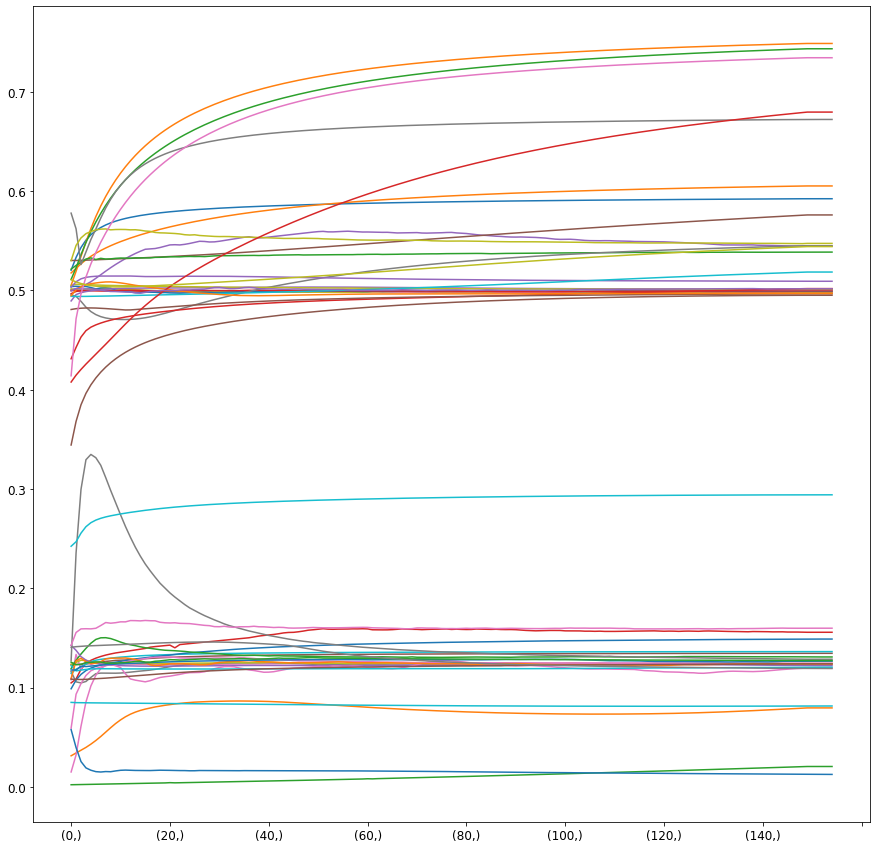

In [71]:
runningMetrics_lr.iloc[2::6,:].iloc[0:50,:].T.plot(figsize=(15,15),legend=False)

In [72]:
runningMetrics_lr.iloc[2::6,:].iloc[0:50,:]

,,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,154
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379,AUC,0.520483,0.533294,0.543315,0.550682,0.556136,0.560248,0.563450,0.566000,0.568082,0.569817,...,0.592322,0.592349,0.592375,0.592401,0.592426,0.592426,0.592426,0.592426,0.592426,0.592426
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_377,AUC,0.505193,0.519258,0.534286,0.548902,0.562366,0.574421,0.585135,0.594727,0.603338,0.611109,...,0.748327,0.748457,0.748587,0.748715,0.748841,0.748841,0.748841,0.748841,0.748841,0.748841
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_378,AUC,0.002087,0.002189,0.002296,0.002404,0.002515,0.002624,0.002731,0.002835,0.002935,0.003032,...,0.019815,0.019976,0.020139,0.020302,0.020466,0.020466,0.020466,0.020466,0.020466,0.020466
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_375,AUC,0.104649,0.108579,0.118424,0.124196,0.127432,0.129600,0.131302,0.132704,0.133841,0.134843,...,0.155916,0.155938,0.155892,0.155783,0.155676,0.155676,0.155676,0.155676,0.155676,0.155676
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_376,AUC,0.500914,0.501890,0.503633,0.506066,0.508793,0.512234,0.515869,0.519466,0.522936,0.526187,...,0.544895,0.544791,0.544763,0.544765,0.544608,0.544608,0.544608,0.544608,0.544608,0.544608
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_374,AUC,0.123070,0.123346,0.123446,0.123709,0.124381,0.125046,0.125696,0.126358,0.126774,0.127373,...,0.134484,0.134489,0.134493,0.134498,0.134470,0.134470,0.134470,0.134470,0.134470,0.134470
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_371,AUC,0.107857,0.133374,0.118499,0.127304,0.123127,0.125183,0.123695,0.125155,0.124433,0.124329,...,0.124204,0.124233,0.124233,0.124252,0.124308,0.124308,0.124308,0.124308,0.124308,0.124308
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_372,AUC,0.116028,0.105737,0.104640,0.106113,0.110214,0.113938,0.114551,0.114484,0.114456,0.114448,...,0.123780,0.123931,0.124042,0.124029,0.123968,0.123968,0.123968,0.123968,0.123968,0.123968
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_373,AUC,0.123512,0.125345,0.127482,0.127315,0.126186,0.125491,0.125067,0.124813,0.124635,0.124526,...,0.123837,0.123934,0.124025,0.124081,0.124082,0.124082,0.124082,0.124082,0.124082,0.124082
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_361,AUC,0.114298,0.118442,0.120714,0.123684,0.126136,0.127548,0.128403,0.129058,0.129659,0.130184,...,0.136192,0.136196,0.136199,0.136202,0.136206,0.136206,0.136206,0.136206,0.136206,0.136206


In [91]:
finalMetrics_lr

size
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Final test loss       1.0703172176779956
                                            Final test AUC        0.5924146175384521
                                            Final test accuracy   0.4012987017631531
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_377 Final test loss       0.9833228082609005
                                            Final test AUC        0.7488732933998108
...                                                                              ...
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_15  Final test AUC        0.5023971796035767
                                            Final test accuracy   0.5048107504844666
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11  Final test loss       1.6155616476873773
                                            Final test AUC        0.4989795684814453
                                            Final test accuracy  0.19553326070308685

[1923 rows x 1 columns]

In [94]:
runningMetrics_lr.columns = np.arange(0,155)

In [98]:
runningMetrics_lr.reset_index().level_0

0       HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379
1       HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379
2       HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379
3       HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379
4       HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379
                           ...                     
3841     HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11
3842     HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11
3843     HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11
3844     HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11
3845     HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11
Name: level_0, Length: 3846, dtype: object

In [102]:
finalMetrics_lr.reset_index().level_0.unique()

array(['HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_377',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_378',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_375',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_376',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_374',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_371',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_372',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_373',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_361',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_365',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_364',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_367',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_366',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_370',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_368',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_363',
       'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_360',
       'HD_fff734bd-f8f6-410

In [104]:
runningMetrics_lr.reset_index().level_0.isin(['hej'])

0       False
1       False
2       False
3       False
4       False
        ...  
3841    False
3842    False
3843    False
3844    False
3845    False
Name: level_0, Length: 3846, dtype: bool

In [106]:
temp = [False if i in finalMetrics_lr.reset_index().level_0.unique() else True for i in runningMetrics_lr.reset_index().level_0]
runningMetrics_lr[temp]

,,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,154


In [32]:
finalMetrics_lr

size
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_379 Final test loss       1.0703172176779956
                                            Final test AUC        0.5924146175384521
                                            Final test accuracy   0.4012987017631531
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_377 Final test loss       0.9833228082609005
                                            Final test AUC        0.7488732933998108
...                                                                              ...
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_15  Final test AUC        0.5023971796035767
                                            Final test accuracy   0.5048107504844666
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_11  Final test loss       1.6155616476873773
                                            Final test AUC        0.4989795684814453
                                            Final test accuracy  0.19553326070308685

[1923 rows x 1 columns]

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [33]:
## Resetting indcies and rename columns
runningMetrics_lr2 = runningMetrics_lr.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics_lr2.columns = runningMetrics_lr2.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics_lr2['id'] = [re.split('-',i)[-1] for i in runningMetrics_lr2.run_id] #np.arange(runningMetrics_lr2.shape[0]).astype(str)#
runningMetrics_lr2

# ## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table_lr = pd.pivot_table(runningMetrics_lr2[['run_id','metric','154','id']],index='id',columns=['metric'])
table_lr.columns = table_lr.columns.get_level_values(1)
table_lr = table_lr.round(7).reset_index()
table_lr

## Preparing the parameter dataframe.
parameters_lr2 = parameters_lr.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters_lr2['id'] = [re.split('-',i)[-1] for i in parameters_lr2.run_id] #np.arange(parameters_lr2.shape[0]).astype(str) #[re.split('_',i)[-1] for i in parameters_lr.run_id]

## Creating the combined table
combined_table_lr = parameters_lr2.merge(table_lr,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table_lr

,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
321,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_58,1,10725,5,3,0.0001,0,2,0.01,0,150,0,quantgau,d62b1e6b8d95_58,0.770243,0.609699,0.899017,0.770233,0.607270,0.892077
57,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_322,1,3300,5,2,0.0001,6,2,0.001,0,150,1,pow,d62b1e6b8d95_322,0.769295,0.609793,1.025276,0.769279,0.607994,1.026104
269,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_109,0,3300,5,1,0.0001,0,2,0.001,0,150,0,pow,d62b1e6b8d95_109,0.765728,0.609536,0.899042,0.765704,0.607570,0.898071
281,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_98,1,3300,1,0,0.001,0,2,0.1,0,150,1,minmax,d62b1e6b8d95_98,0.758545,0.609978,0.906770,0.758532,0.605583,0.908269
498,HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_153,1,3300,5,3,0.0001,3,2,0.001,0,150,0,std,b36f03f5d186_153,0.757047,0.608576,1.034854,0.757034,0.606462,1.032217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,HD_914f915c-2cac-473e-bea5-c26e4c83673c_86,0,10725,3,0,10,2,4,0.01,0,150,0,quantgau,c26e4c83673c_86,NaN,NaN,NaN,NaN,NaN,NaN
399,HD_914f915c-2cac-473e-bea5-c26e4c83673c_84,0,10725,0,3,0.001,3,3,0.01,0,150,1,minmax,c26e4c83673c_84,NaN,NaN,NaN,NaN,NaN,NaN
405,HD_914f915c-2cac-473e-bea5-c26e4c83673c_68,1,10725,5,2,0.1,0,3,0.001,1,150,0,quantgau,c26e4c83673c_68,NaN,NaN,NaN,NaN,NaN,NaN
433,HD_914f915c-2cac-473e-bea5-c26e4c83673c_48,0,3300,0,3,0.001,3,3,0.01,0,150,0,stacked,c26e4c83673c_48,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
## How many NaN rows?
print(len(combined_table_lr[combined_table_lr.isnull().any(axis=1)]))
# 14 in total: 12 from run 881, 1 (last child run) from run 985 , 1 (last child run) from run 453
# HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_380 doesn't exist in the experiment window in Azure, looks like it was initialised but not run (hyperparams file has it, metrics file does not)
# HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_170 doesn't exist in the experiment window in Azure, looks like it was initialised but not run (hyperparams file has it, metrics file does not)
# HD_914f915c-2cac-473e-bea5-c26e4c83673c has 11x NaNs because they failed (but metrics file does have all except _84! so they are included)
# the 12 missed runs seems to be an error
combined_table_lr[combined_table_lr.isnull().any(axis=1)]

11


,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
385,HD_914f915c-2cac-473e-bea5-c26e4c83673c_97,1,21450,5,2,10000000000,3,2,0.001,0,150,1,std,c26e4c83673c_97,NaN,NaN,NaN,NaN,NaN,NaN
388,HD_914f915c-2cac-473e-bea5-c26e4c83673c_90,1,21450,1,3,0.001,0,3,0.1,0,150,0,std,c26e4c83673c_90,NaN,NaN,NaN,NaN,NaN,NaN
389,HD_914f915c-2cac-473e-bea5-c26e4c83673c_100,1,21450,3,1,1000,5,1,0.001,0,150,0,std,c26e4c83673c_100,NaN,NaN,NaN,NaN,NaN,NaN
391,HD_914f915c-2cac-473e-bea5-c26e4c83673c_95,1,10725,5,3,10000,3,4,0.01,0,150,0,None,c26e4c83673c_95,NaN,NaN,NaN,NaN,NaN,NaN
392,HD_914f915c-2cac-473e-bea5-c26e4c83673c_93,0,10725,1,3,10000,0,1,0.1,1,150,0,std,c26e4c83673c_93,NaN,NaN,NaN,NaN,NaN,NaN
395,HD_914f915c-2cac-473e-bea5-c26e4c83673c_82,1,21450,1,3,10000,0,4,0.0001,0,150,1,stacked,c26e4c83673c_82,NaN,NaN,NaN,NaN,NaN,NaN
396,HD_914f915c-2cac-473e-bea5-c26e4c83673c_86,0,10725,3,0,10,2,4,0.01,0,150,0,quantgau,c26e4c83673c_86,NaN,NaN,NaN,NaN,NaN,NaN
399,HD_914f915c-2cac-473e-bea5-c26e4c83673c_84,0,10725,0,3,0.001,3,3,0.01,0,150,1,minmax,c26e4c83673c_84,NaN,NaN,NaN,NaN,NaN,NaN
405,HD_914f915c-2cac-473e-bea5-c26e4c83673c_68,1,10725,5,2,0.1,0,3,0.001,1,150,0,quantgau,c26e4c83673c_68,NaN,NaN,NaN,NaN,NaN,NaN
433,HD_914f915c-2cac-473e-bea5-c26e4c83673c_48,0,3300,0,3,0.001,3,3,0.01,0,150,0,stacked,c26e4c83673c_48,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc_lr = pd.pivot_table(combined_table_lr[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc_lr = pd.pivot_table(combined_table_lr[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc_lr = pd.DataFrame(np.sort(temp_auc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc_lr.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc_lr = pd.DataFrame(np.sort(temp_acc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc_lr.columns.get_level_values(1))#.loc[0:10]
# final_output

In [36]:
tempFinal_v0_lr = combined_table_lr[np.isin(combined_table_lr.AUC,final_output_auc_lr.loc[0].values.flatten())].reset_index()
tempFinal_v0_lr.index = tempFinal_v0_lr.loc[:,'label-type']
tempFinal_v0_lr

,index,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,...,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
2,321,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_58,1,10725,5,3,0.0001,0,2,0.01,...,150,0,quantgau,d62b1e6b8d95_58,0.770243,0.609699,0.899017,0.770233,0.607270,0.892077
4,285,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_94,1,10725,3,2,10000000000,0,4,0.01,...,150,0,minmax,d62b1e6b8d95_94,0.724517,0.412573,42711.261357,0.724506,0.408811,9438.476361
3,459,HD_914f915c-2cac-473e-bea5-c26e4c83673c_21,1,21450,3,3,10000000000,0,3,0.001,...,150,0,pow,c26e4c83673c_21,0.638079,0.299720,1.521505,0.638052,0.309349,1.511623
1,358,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_21,1,3300,3,3,0.0001,3,1,0.001,...,150,0,stacked,d62b1e6b8d95_21,0.615782,0.421687,1.084780,0.615771,0.427520,1.084089
0,638,HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_7,1,3300,1,2,0.0001,4,0,0.0001,...,150,1,stacked,b36f03f5d186_7,0.580920,0.547298,0.676906,0.580908,0.553431,0.676053


In [37]:
first_step_lr = tempFinal_v0_lr.copy(deep=True).drop(['run_id','label-type','n-epochs','id'],axis=1).sort_index().round({'AUC':3,
                                                                                                              'Accuracy':3,
                                                                                                              'Loss':3,
                                                                                                              'Train AUC':3,
                                                                                                              'Train Accuracy':3,
                                                                                                              'Train Loss':3}).rename({'index':'id'},axis=1)

###     First variables for indentification, the data related variables, estimation parameters, model parameters and then performance.
columns_on_top_lr = ['id','featureset','pre-processing','pastobs-in-percentage','feature-lags',
                  'batch-shuffle','batch-size','learning-rate','l2-penalty']
residual_lr = [i for i in first_step_lr.columns if i not in columns_on_top_lr]
correct_ordered_lr = []
correct_ordered_lr += columns_on_top_lr
correct_ordered_lr += residual_lr
results_table_lr = first_step_lr.T.loc[correct_ordered_lr,:]

iterables = [['lr'], results_table_lr.columns]

results_table_lr.columns = pd.MultiIndex.from_product(iterables, names=['first', 'second'])

results_table_lr
# first_step.T

first                       lr                                             
second                       0        1         2            3            4
id                         638      358       321          459          285
featureset                   2        3         3            3            2
pre-processing         stacked  stacked  quantgau          pow       minmax
pastobs-in-percentage        1        0         0            0            0
feature-lags                 1        3         5            3            3
batch-shuffle                1        1         1            1            1
batch-size                3300     3300     10725        21450        10725
learning-rate           0.0001    0.001      0.01        0.001         0.01
l2-penalty              0.0001   0.0001    0.0001  10000000000  10000000000
l2-type                      4        3         0            0            0
loss-from-logits             0        0         0            0            0
AUC                      0.581    0.616      0.77        0.638        0.725
Accuracy                 0.547    0.422      0.61          0.3        0.413
Loss                     0.677    1.085     0.899        1.522      42711.3
Train AUC                0.581    0.616      0.77        0.638        0.725
Train Accuracy           0.553    0.428     0.607        0.309        0.409
Train Loss               0.676    1.084     0.892        1.512      9438.48

In [38]:
# agg_table = pd.concat([first_step.T.loc[correct_ordered,:],
#                        first_step_lr.T.loc[correct_ordered_lr,:]],axis=1).fillna('')

agg_table = pd.concat([results_table,
                       results_table_lr],axis=1).fillna('')

# agg_table.columns = agg_table.columns.sort_values()
agg_table
# agg_table.loc[:, agg_table.columns.sort_values()]

first                       nn                                             lr  \
second                       0          1        2        3        4        0   
nn-type                   ffnn       lstm     lstm     ffnn     lstm            
id                         818         65      883      737      743      638   
featureset                   1          1        3        0        3        2   
pre-processing             pow        std      std      pow      std  stacked   
pastobs-in-percentage        1          0        0        0        1        1   
feature-lags                 5          5        3        5        3        1   
batch-norm                   1          0        1        1        1            
batch-shuffle                1          1        1        1        0        1   
batch-size               10725      10725    10725     3300    10725     3300   
dropout-ratio                0          0      0.1        0        0            
learning-rate              0.1       0.01     0.01     0.01    0.001   0.0001   
n-layers                     3          4        4        4        4            
activation-inner          relu  leakyrelu  sigmoid     tanh     relu            
activation-output      softmax    softmax  softmax  softmax  softmax            
first-layer-neurons        128        128      128       32      128            
second-layer-neurons       128         64       32      128       32            
AUC                      0.711      0.741    0.804    0.684    0.753    0.581   
Accuracy                 0.533      0.382    0.581    0.274    0.397    0.547   
Loss                     0.971      1.543    0.983    1.667    1.492    0.677   
Train AUC                0.711      0.741    0.804    0.684    0.753    0.581   
Train Accuracy           0.749      0.636    0.665    0.415    0.466    0.553   
Train Loss                 0.5      0.774    0.771    1.363    1.254    0.676   
l2-penalty                                                             0.0001   
l2-type                                                                     4   
loss-from-logits                                                            0   

first                                                               
second                       1         2            3            4  
nn-type                                                             
id                         358       321          459          285  
featureset                   3         3            3            2  
pre-processing         stacked  quantgau          pow       minmax  
pastobs-in-percentage        0         0            0            0  
feature-lags                 3         5            3            3  
batch-norm                                                          
batch-shuffle                1         1            1            1  
batch-size                3300     10725        21450        10725  
dropout-ratio                                                       
learning-rate            0.001      0.01        0.001         0.01  
n-layers                                                            
activation-inner                                                    
activation-output                                                   
first-layer-neurons                                                 
second-layer-neurons                                                
AUC                      0.616      0.77        0.638        0.725  
Accuracy                 0.422      0.61          0.3        0.413  
Loss                     1.085     0.899        1.522      42711.3  
Train AUC                0.616      0.77        0.638        0.725  
Train Accuracy           0.428     0.607        0.309        0.409  
Train Loss               1.084     0.892        1.512      9438.48  
l2-penalty              0.0001    0.0001  10000000000  10000000000  
l2-type                      3         0            0            0  
loss-from-logits  

In [39]:
agg_table.loc[:,(['nn','lr'],['0','1','3'])]

first                       nn                           lr           \
second                       0          1        3        0        1   
nn-type                   ffnn       lstm     ffnn                     
id                         818         65      737      638      358   
featureset                   1          1        0        2        3   
pre-processing             pow        std      pow  stacked  stacked   
pastobs-in-percentage        1          0        0        1        0   
feature-lags                 5          5        5        1        3   
batch-norm                   1          0        1                     
batch-shuffle                1          1        1        1        1   
batch-size               10725      10725     3300     3300     3300   
dropout-ratio                0          0        0                     
learning-rate              0.1       0.01     0.01   0.0001    0.001   
n-layers                     3          4        4                     
activation-inner          relu  leakyrelu     tanh                     
activation-output      softmax    softmax  softmax                     
first-layer-neurons        128        128       32                     
second-layer-neurons       128         64      128                     
AUC                      0.711      0.741    0.684    0.581    0.616   
Accuracy                 0.533      0.382    0.274    0.547    0.422   
Loss                     0.971      1.543    1.667    0.677    1.085   
Train AUC                0.711      0.741    0.684    0.581    0.616   
Train Accuracy           0.749      0.636    0.415    0.553    0.428   
Train Loss                 0.5      0.774    1.363    0.676    1.084   
l2-penalty                                           0.0001   0.0001   
l2-type                                                   4        3   
loss-from-logits                                          0        0   

first                               
second                           3  
nn-type                             
id                             459  
featureset                       3  
pre-processing                 pow  
pastobs-in-percentage            0  
feature-lags                     3  
batch-norm                          
batch-shuffle                    1  
batch-size                   21450  
dropout-ratio                       
learning-rate                0.001  
n-layers                            
activation-inner                    
activation-output                   
first-layer-neurons                 
second-layer-neurons                
AUC                          0.638  
Accuracy                       0.3  
Loss                         1.522  
Train AUC                    0.638  
Train Accuracy               0.309  
Train Loss                   1.512  
l2-penalty             10000000000  
l2-type                          0  
loss-from-logits                 0

In [40]:
agg_table.sortlevel('second',axis=1)

AttributeError: 'DataFrame' object has no attribute 'sortlevel'

In [ ]:
agg_table.reorder_levels(['second','first'],axis=1)

In [ ]:
tempFinal_v1_lr = combined_table_lr[np.isin(combined_table_lr.Accuracy,final_output_acc_lr.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1_lr.index = tempFinal_v1_lr.loc[:,'label-type']
tempFinal_v1_lr

In [ ]:
temp = combined_table[(combined_table.loc[:,'label-type']=='0')&\
                      (combined_table_lr.loc[:,'loss-from-logits']=='1')&\
                      (combined_table.AUC>0.5)]

cols_not_plot = []
cols_to_plot = []

for i,col in enumerate(temp.columns):
    if (temp.loc[:,col].unique().shape[0]>1)&(temp.loc[:,col].unique().shape[0]<7):
        cols_to_plot.append(col)
        print(col,': ',temp.loc[:,col].unique(),'\n')
    else:
        cols_not_plot.append(col)

# Label types

Label type 0: 2 classes - equal split

Label type 1: 3 classes - equal split

Label type 2: 3 classes - non-equal split

Label type 3: 5 classes - equal split

Label type 4: 5 classes - non-equal split

In [ ]:
import seaborn as sns

# temp = combined_table_lr[(combined_table_lr.loc[:,'label-type']=='4')&\
#                       (combined_table_lr.loc[:,'loss-from-logits']=='1')&\
#                       (combined_table_lr.AUC>0.5)]

fig,ax = plt.subplots(5,3,figsize=(17,40))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
# plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.weight': 'normal'})
k = 0

for i in np.arange(5):
    for j in np.arange(3):
        


        if k < len(cols_to_plot):
            temp_2 = pd.pivot_table(temp,values='AUC',columns=cols_to_plot[k],index='run_id').reset_index()

            # sns.set_theme(style="whitegrid")
            # tips = sns.load_dataset("tips")
            # ax = sns.violinplot(x=tips["total_bill"])
            sns.boxplot(data=temp_2,ax=ax[i,j],color='gray')#,bw='scott'
#             ax[i,j].set_xticks(fontsize=12)
#             ax[i,j].set_yticks(fontsize=12)
            # plt.legend(fontsize=14)
            ax[i,j].set_xlabel(temp_2.columns.name,fontsize=12,fontweight='bold')


            k +=1

plt.show()

In [38]:
stop

NameError: name 'stop' is not defined

# reading in the market data (done automatically atm)

In [ ]:
file

In [ ]:
data

In [ ]:
data

In [ ]:
data.columns

### Dropping ETFS and market indices

In [ ]:
data.Ticker.unique()

In [ ]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [ ]:
data.Ticker.unique()

In [ ]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [ ]:
data.columns

In [ ]:
data

In [ ]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
#                                                     'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                      'macd_diff',
                                                      'macd_signal',
                                                    'dis5',
                                                    'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,ticker_dummies=False)

## Splitting the data

## Adding ticker dummies

In [ ]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

In [ ]:
X.columns

## Constructing our final train/validation sets

In [ ]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

In [ ]:
X_train

In [ ]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


## Pre-processing

In [ ]:
{i:colname for i,colname in enumerate(train_ds.columns)}

In [ ]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing(X_train,X_test,ppdict)

In [ ]:
ppX_train.iloc[:,0].mean(),ppX_train.iloc[:,0].std()

## Prepping for models

In [ ]:
N_VALIDATION = val_y.shape[0] #int(1e3)
N_TRAIN = train_y.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

## A Logistic Regression model in TF/Keras

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=0) #(val_features, val_labels))

In [ ]:
model.evaluate(validate_ds,  val_y, verbose=2)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs